# Neural Image Caption Generator
##### This is a Deep Learning model build using tensorflow and Keras, for genarating Captions for Images in English

In [1]:
import tensorflow as tf
from tensorflow import keras

In [5]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("textFiles/tokens_clean.txt", 'r') as file:
    content = file.read()

In [6]:
# json_acceptable_string

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [7]:
type(content)

dict

In [8]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 437466


In [9]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 8441


In [10]:
freq_cnt

{'a': 62995,
 'child': 1545,
 'in': 18987,
 'pink': 739,
 'dress': 348,
 'is': 9345,
 'climbing': 507,
 'up': 1302,
 'set': 109,
 'of': 6723,
 'stairs': 109,
 'an': 2432,
 'entry': 1,
 'way': 53,
 'girl': 3328,
 'going': 149,
 'into': 1074,
 'wooden': 284,
 'building': 511,
 'little': 1768,
 'playhouse': 6,
 'the': 18420,
 'to': 3176,
 'her': 1178,
 'cabin': 4,
 'black': 3848,
 'dog': 8138,
 'and': 8863,
 'spotted': 38,
 'are': 3505,
 'fighting': 133,
 'tri': 14,
 'colored': 221,
 'playing': 2008,
 'with': 7765,
 'each': 430,
 'other': 773,
 'on': 10746,
 'road': 398,
 'white': 3959,
 'brown': 2578,
 'spots': 29,
 'staring': 57,
 'at': 2916,
 'street': 944,
 'two': 5643,
 'dogs': 2125,
 'different': 46,
 'breeds': 5,
 'looking': 744,
 'pavement': 48,
 'moving': 41,
 'toward': 146,
 'covered': 372,
 'paint': 62,
 'sits': 577,
 'front': 1386,
 'painted': 64,
 'rainbow': 22,
 'hands': 246,
 'bowl': 30,
 'sitting': 1368,
 'large': 1237,
 'small': 1278,
 'grass': 1622,
 'plays': 526,
 'fing

In [11]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [12]:
threshold = 5

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 2644


In [13]:
total_words[:11]

['a', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two']

#### Prepare train and test data

In [14]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("textFiles/trainImages.txt", 'r') as file:
    train_file_data = file.read()

with open ("textFiles/testImages.txt", 'r') as file:
    test_file_data = file.read()

In [15]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [16]:
train_data[:7]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079']

In [17]:
test_data[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

In [18]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [19]:
train_content['1007320043_627395c3d8']

['startseq a child playing on a rope net  endseq',
 'startseq a little girl climbing on red roping  endseq',
 'startseq a little girl in pink climbs a rope bridge at the park  endseq',
 'startseq a small child grips onto the red ropes at the playground  endseq',
 'startseq the small child climbs on a red ropes on a playground  endseq']

### Transfer Learning

#### Extract features from Image using a ResNet50 Architecture

In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))

In [21]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [22]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [23]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

def preprocess_image (img):
    img = load_img(img, target_size=(224, 224))
    img = img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)
Normalized image accoring to ResNet50 requirement


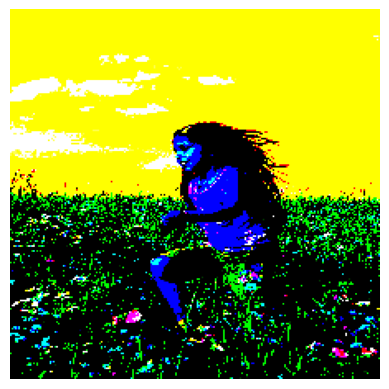

In [24]:
import matplotlib.pyplot as plt

img = preprocess_image("Images/174466741_329a52b2fe.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
print("Normalized image accoring to ResNet50 requirement")
plt.show()

In [25]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [27]:
train_encoding = {}
# Create a dictionary of iamgeID and its feature vector

for index, imageID in enumerate (train_data):
    image_path = "Images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress...   STEP --> ", index) # 7000 Encoding Steps (250 ms / Step)

1/1 [==============================] - 1s 859ms/step
Encoding in progress...   STEP -->  0
1/1 [==============================] - 0s 97ms/step
Encoding in progress...   STEP -->  100
1/1 [==============================] - 0s 95ms/step
Encoding in progress...   STEP -->  200
1/1 [==============================] - 0s 97ms/step
Encoding in progress...   STEP -->  300
1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 104ms/step
Encoding in progress...   STEP -->  400
1/1 [==============================] - 0s 96ms/step
Encoding in progress...   STEP -->  500
1/1 [==============================] - 0s 91ms/step
Encoding in progress...   STEP -->  600
1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 92ms/step
Encoding in progress...   STEP -->  700
1/1 [==============================] - 0s 113ms/step
Encoding in progress...   STEP -->  800
1/1 [==============================] - 0s 109ms/step
Encoding in progress...   STEP -->  900
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 100ms/step
Encoding in progress...   STEP -->  1000
1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 100ms/step
Encoding in progress...   STEP -->  1100
1/1 [==============================] - 0s 98ms/step
Encoding in progress...   STEP -->  1200
1/1 [==============================] - 0s 101ms/step
Encoding in progress...   STEP -->  1300
1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 119ms/step
Encoding in progress...   STEP -->  1400
1/1 [==============================] - 0s 90ms/step
Encoding in progress...   STEP -->  1500
1/1 [==============================] - 0s 99ms/step
Encoding in progress...   STEP -->  1600
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 110ms/step
Encoding in progress...   STEP -->  1700
1/1 [==============================] - 0s 103ms/step
Encoding in progress...   STEP -->  1800
1/1 [==============================] - 0s 122ms/step
Encoding in progress...   STEP -->  1900
1/1 [==============================] - 0s 112ms/step
Encoding in progress...   STEP -->  2000
1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 116ms/step
Encoding in progress...   STEP -->  2100
1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 109ms/step
Encoding in progress...   STEP -->  2200
1/1 [==============================] - 0s 111ms/step
Encoding in progress...   STEP -->  2300
1/1 [==============================] - 0s 102ms/step
Encoding in progress...   STEP -->  2400
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 107ms/step
Encoding in progress...   STEP -->  2500
1/1 [==============================] - 0s 147ms/step
Encoding in progress...   STEP -->  2600
1/1 [==============================] - 0s 159ms/step
Encoding in progress...   STEP -->  2700
1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 153ms/step
Encoding in progress...   STEP -->  2800
1/1 [==============================] - 0s 137ms/step
Encoding in progress...   STEP -->  2900
1/1 [==============================] - 0s 153ms/step
Encoding in progress...   STEP -->  3000
1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 152ms/step
Encoding in progress...   STEP -->  3100
1/1 [==============================] - 0s 162ms/step
Encoding in progress...   STEP -->  3200
1/1 [==============================] - 0s 154ms/step
Encoding in progress...   STEP -->  3300
1/1 [==============================] - 0s 161ms/step


1/1 [==============================] - 0s 172ms/step
Encoding in progress...   STEP -->  3400
1/1 [==============================] - 0s 157ms/step
Encoding in progress...   STEP -->  3500
1/1 [==============================] - 0s 159ms/step
Encoding in progress...   STEP -->  3600
1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 163ms/step
Encoding in progress...   STEP -->  3700
1/1 [==============================] - 0s 168ms/step
Encoding in progress...   STEP -->  3800
1/1 [==============================] - 0s 180ms/step
Encoding in progress...   STEP -->  3900
1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 163ms/step
Encoding in progress...   STEP -->  4000
1/1 [==============================] - 0s 170ms/step
Encoding in progress...   STEP -->  4100
1/1 [==============================] - 0s 173ms/step
Encoding in progress...   STEP -->  4200
1/1 [==============================] - 0s 177ms/step
Encoding in progress...   STEP -->  4300


1/1 [==============================] - 0s 181ms/step
Encoding in progress...   STEP -->  4400
1/1 [==============================] - 0s 188ms/step
Encoding in progress...   STEP -->  4500
1/1 [==============================] - 0s 188ms/step
Encoding in progress...   STEP -->  4600
1/1 [==============================] - 0s 199ms/step


1/1 [==============================] - 0s 188ms/step
Encoding in progress...   STEP -->  4700
1/1 [==============================] - 0s 195ms/step
Encoding in progress...   STEP -->  4800
1/1 [==============================] - 0s 192ms/step
Encoding in progress...   STEP -->  4900
1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 183ms/step
Encoding in progress...   STEP -->  5000
1/1 [==============================] - 0s 187ms/step
Encoding in progress...   STEP -->  5100
1/1 [==============================] - 0s 200ms/step
Encoding in progress...   STEP -->  5200
1/1 [==============================] - 0s 199ms/step


1/1 [==============================] - 0s 201ms/step
Encoding in progress...   STEP -->  5300
1/1 [==============================] - 0s 208ms/step
Encoding in progress...   STEP -->  5400
1/1 [==============================] - 0s 208ms/step
Encoding in progress...   STEP -->  5500
1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 199ms/step
Encoding in progress...   STEP -->  5600
1/1 [==============================] - 0s 203ms/step
Encoding in progress...   STEP -->  5700
1/1 [==============================] - 0s 206ms/step
Encoding in progress...   STEP -->  5800
1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 215ms/step
Encoding in progress...   STEP -->  5900
1/1 [==============================] - 0s 227ms/step
Encoding in progress...   STEP -->  6000
1/1 [==============================] - 0s 209ms/step
Encoding in progress...   STEP -->  6100
1/1 [==============================] - 0s 212ms/step


1/1 [==============================] - 0s 235ms/step
Encoding in progress...   STEP -->  6200
1/1 [==============================] - 0s 237ms/step
Encoding in progress...   STEP -->  6300
1/1 [==============================] - 0s 259ms/step
Encoding in progress...   STEP -->  6400
1/1 [==============================] - 0s 234ms/step


1/1 [==============================] - 0s 244ms/step
Encoding in progress...   STEP -->  6500
1/1 [==============================] - 0s 256ms/step
Encoding in progress...   STEP -->  6600
1/1 [==============================] - 0s 268ms/step
Encoding in progress...   STEP -->  6700
1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 273ms/step
Encoding in progress...   STEP -->  6800
1/1 [==============================] - 0s 271ms/step
Encoding in progress...   STEP -->  6900
1/1 [==============================] - 0s 271ms/step


In [31]:
# with open('Train_Enc_7000.txt', 'wt') as hrx:
#     hrx.write(str(train_encoding))

In [32]:
# Store the above computed features on the disk
# Use pickle to dump the entire data
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)

In [34]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

for index, imageID in enumerate (test_data):
    image_path = "Images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

1/1 [==============================] - 0s 288ms/step
Encoding in progress... STEP 0
1/1 [==============================] - 0s 280ms/step
Encoding in progress... STEP 100
1/1 [==============================] - 0s 276ms/step
Encoding in progress... STEP 200
1/1 [==============================] - 0s 276ms/step
Encoding in progress... STEP 300
1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 280ms/step
Encoding in progress... STEP 400
1/1 [==============================] - 0s 315ms/step


1/1 [==============================] - 0s 282ms/step
Encoding in progress... STEP 500
1/1 [==============================] - 0s 280ms/step
Encoding in progress... STEP 600
1/1 [==============================] - 0s 284ms/step
Encoding in progress... STEP 700
1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 289ms/step
Encoding in progress... STEP 800
1/1 [==============================] - 0s 307ms/step
Encoding in progress... STEP 900
1/1 [==============================] - 0s 286ms/step


In [35]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

#### Pre-process the Captions

In [36]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [37]:
print(len(index_to_word))

2644


In [38]:
print(index_to_word[5])
print(word_to_index['is'])

is
5


In [39]:
# Add startseq and endseq also to the mappings
index_to_word[2645] = 'startseq'
word_to_index['startseq'] = 2645

index_to_word[2646] = 'endseq'
word_to_index['endseq'] = 2646

VOCAB_SIZE = len(word_to_index) + 1

In [40]:
print(VOCAB_SIZE)

2647


In [42]:
with open("textFiles/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [43]:
with open("textFiles/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [44]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [45]:
print(max_len)

38


In [46]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 Billion English words
file = open("glove.6B.50d.txt",encoding='utf8')

In [47]:
# Create a mapping from word to embedding
word_to_embedding = {}

for line in file:
    values = line.split()

    word = values[0]
    embedding = np.array (values[1:], dtype='float')
    word_to_embedding[word] = embedding

file.close()

In [48]:
word_to_embedding["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [49]:
EMBEDDING_DIM = 50

def get_embedding_matrix():
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

    for word, index in word_to_index.items():
        embedding = word_to_embedding.get(word)

        if embedding is not None:
            embedding_matrix[index] = embedding

    return embedding_matrix

In [50]:
index_to_embedding = get_embedding_matrix()
print(index_to_embedding.shape)

(2647, 50)


### Define Model Architecture
##### Build a Neural Network using Keras Functional API

In [51]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ResNet goes into following input layer 
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [52]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 essentially captures the entire sentence that has been generated till now

In [53]:
from tensorflow.keras.layers import add

# Decode the inputs

# So effectively, an image (224x224x3) goes through ResNet50
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder 

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Add the two above tensors
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model(inputs=[inp_img_features, inp_cap], outputs=outputs)

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 50)       132350      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [55]:
# Preinitialise Embedding layer
model.layers[2].set_weights([index_to_embedding])
model.layers[2].trainable = False

In [56]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

#### Create a Data Loader

In [57]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n=0     

### Train Model

In [58]:
epochs = 36
batch_size = 1000
steps = len(train_content)//batch_size 

In [ ]:
for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')

4/7 [================>.............] - ETA: 10:39 - loss: 7.1554

In [ ]:
keras.utils.plot_model(model, "Model.png", show_shapes=True)

# Refrences: 

    Main: https://www.analyticsvidhya.com/blog/2021/12/step-by-step-guide-to-build-image-caption-generator-using-deep-learning/
    
    CNN: https://www.analyticsvidhya.com/blog/2021/07/convolution-neural-network-better-understanding/
    LSTM: https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/
    Residual Networks (Computer Vision): https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
    Deep Learning with Python by Fraçois Chollet

## Keras
    https://keras.io/guides/serialization_and_saving/
    https://keras.io/guides/functional_api/

## Deep Residual Learning for Image Recognition
    https://www.ijcai.org/Proceedings/15/Papers/593.pdf
    https://arxiv.org/abs/1411.4555v2
    https://arxiv.org/abs/1512.03385
    
    https://jair.org/index.php/jair/article/view/10833
